In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline  # Use imbalanced-learn's pipeline to integrate SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.exceptions import NotFittedError
from imblearn.under_sampling import RandomUnderSampler


# Display all columns
pd.set_option('display.max_columns', None)

In [3]:
# Load application data
train_data = pd.read_csv('/home/ignatiusvmk/Downloads/home-credit-default-risk/application_train.csv')
test_data = pd.read_csv('/home/ignatiusvmk/Downloads/home-credit-default-risk/application_test.csv')

# Checking the target variable distribution
train_data['TARGET'].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

In [4]:
# Display a sample of the data
train_data.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
train_data.shape

(307511, 122)

In [6]:
test_data.shape

(48744, 121)

In [7]:
cols_to_drop = [
    'FLAG_MOBIL', # Low variance
    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
    'APARTMENTS_MODE', 'APARTMENTS_MEDI', 'APARTMENTS_AVG',
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
    'AMT_REQ_CREDIT_BUREAU_MON', 'WALLSMATERIAL_MODE', 'FLAG_EMAIL', 'FLAG_PHONE', 'FLAG_WORK_PHONE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE'
]
train_data.drop(columns=cols_to_drop, inplace=True)

In [8]:
# Calculate the percentage of missing values for each column
null_percentage = train_data.isnull().mean() * 100

# Display the DataFrame before cleaning
print(f"Original shape: {train_data.shape}")

# Specify the column to preserve
columns_to_preserve = ['SK_ID_CURR']

# Drop columns where more than 35% of the values are missing, except for 'SK_ID_CURR'
columns_to_drop = null_percentage[null_percentage > 35].index
columns_to_drop = [col for col in columns_to_drop if col not in columns_to_preserve]  # Exclude 'SK_ID_CURR'

# Drop the columns
train_data = train_data.drop(columns=columns_to_drop)

# Display the cleaned DataFrame
print(f"New shape after dropping columns with >35% null values (except 'SK_ID_CURR'): {train_data.shape}")


Original shape: (307511, 85)
New shape after dropping columns with >35% null values (except 'SK_ID_CURR'): (307511, 43)


In [9]:
# Load bureau data
bureau = pd.read_csv('/home/ignatiusvmk/Downloads/home-credit-default-risk/bureau.csv')

bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [10]:
bureau.shape

(1716428, 17)

In [11]:
# Aggregation example: Sum and mean of credit amount
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT_SUM': ['sum', 'mean'],
    'CREDIT_DAY_OVERDUE': ['max'],
    'DAYS_CREDIT': ['mean'],
}).reset_index()

bureau_agg.head()

SK_ID_CURR AMT_CREDIT_SUM                CREDIT_DAY_OVERDUE  DAYS_CREDIT
                        sum           mean                max         mean
0     100001    1453365.000  207623.571429                  0  -735.000000
1     100002     865055.565  108131.945625                  0  -874.000000
2     100003    1017400.500  254350.125000                  0 -1400.750000
3     100004     189037.800   94518.900000                  0  -867.000000
4     100005     657126.000  219042.000000                  0  -190.666667

In [12]:
# Rename the columns
bureau_agg.columns = ['SK_ID_CURR', 'CREDIT_SUM_TOTAL', 'CREDIT_SUM_MEAN', 'CREDIT_OVERDUE_MAX', 'CREDIT_DURATION_MEAN']
bureau_agg.head()

,SK_ID_CURR,CREDIT_SUM_TOTAL,CREDIT_SUM_MEAN,CREDIT_OVERDUE_MAX,CREDIT_DURATION_MEAN
0,100001,1453365.000,207623.571429,0,-735.000000
1,100002,865055.565,108131.945625,0,-874.000000
2,100003,1017400.500,254350.125000,0,-1400.750000
3,100004,189037.800,94518.900000,0,-867.000000
4,100005,657126.000,219042.000000,0,-190.666667


In [13]:
bureau_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305811 entries, 0 to 305810
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SK_ID_CURR            305811 non-null  int64  
 1   CREDIT_SUM_TOTAL      305811 non-null  float64
 2   CREDIT_SUM_MEAN       305809 non-null  float64
 3   CREDIT_OVERDUE_MAX    305811 non-null  int64  
 4   CREDIT_DURATION_MEAN  305811 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 11.7 MB


In [14]:
# Merge with train data
train_data = train_data.merge(bureau_agg, on='SK_ID_CURR', how='left')
test_data = test_data.merge(bureau_agg, on='SK_ID_CURR', how='left')

In [15]:
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_SUM_TOTAL,CREDIT_SUM_MEAN,CREDIT_OVERDUE_MAX,CREDIT_DURATION_MEAN
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,2.0,2.0,-1134.0,0.0,1.0,865055.565,108131.945625,0.0,-874.00
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,NaN,0.0,0.0,-828.0,0.0,0.0,1017400.500,254350.125000,0.0,-1400.75
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,0.0,0.0,-815.0,0.0,0.0,189037.800,94518.900000,0.0,-867.00
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,NaN,0.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,NaN,0.0,0.0,-1106.0,0.0,0.0,146250.000,146250.000000,0.0,-1149.00


In [16]:
# Load bureau balance data
bureau_balance = pd.read_csv('/home/ignatiusvmk/Downloads/home-credit-default-risk/bureau_balance.csv')

# Replace categorical values with numeric ones
bureau_balance['STATUS'] = bureau_balance['STATUS'].replace(['C', '0'], 0).replace(['1', '2', '3', '4', '5'], 1)

# Convert the STATUS column to numeric to handle any unexpected non-numeric values
bureau_balance['STATUS'] = pd.to_numeric(bureau_balance['STATUS'], errors='coerce')

# Group by SK_ID_BUREAU and aggregate status as sum (missed payments) and count (total months)
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
    'STATUS': ['sum', 'count']
}).reset_index()

# Rename the columns
bureau_balance_agg.columns = ['SK_ID_BUREAU', 'MISSED_PAYMENTS', 'TOTAL_MONTHS']

bureau_balance_agg.head()

,SK_ID_BUREAU,MISSED_PAYMENTS,TOTAL_MONTHS
0,5001709,0.0,86
1,5001710,0.0,53
2,5001711,0.0,3
3,5001712,0.0,19
4,5001713,0.0,0


In [17]:
# Load POS_CASH_balance data
pos_cash_balance = pd.read_csv('/home/ignatiusvmk/Downloads/home-credit-default-risk/POS_CASH_balance.csv')

# Aggregation example: Count of active loans
pos_cash_agg = pos_cash_balance.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': 'count',  # Count of months with POS loans
    'SK_DPD': ['mean', 'sum'],  # Delay in payment (mean and total)
}).reset_index()

# Rename columns
pos_cash_agg.columns = ['SK_ID_CURR', 'POS_LOANS_COUNT', 'POS_DPD_MEAN', 'POS_DPD_TOTAL']

# Merge with train and test data
train_data = train_data.merge(pos_cash_agg, on='SK_ID_CURR', how='left')
test_data = test_data.merge(pos_cash_agg, on='SK_ID_CURR', how='left')

In [18]:
# Load credit card balance data
credit_card_balance = pd.read_csv('/home/ignatiusvmk/Downloads/home-credit-default-risk/credit_card_balance.csv')

# Aggregation example: Average balance over time
credit_card_agg = credit_card_balance.groupby('SK_ID_CURR').agg({
    'AMT_BALANCE': ['mean', 'max'],
    'MONTHS_BALANCE': 'count'
}).reset_index()

# Rename columns
credit_card_agg.columns = ['SK_ID_CURR', 'CREDIT_BALANCE_MEAN', 'CREDIT_BALANCE_MAX', 'CREDIT_CARD_MONTHS']

# Merge with train and test data
train_data = train_data.merge(credit_card_agg, on='SK_ID_CURR', how='left')
test_data = test_data.merge(credit_card_agg, on='SK_ID_CURR', how='left')

In [19]:
# Load installments payments data
installments_payments = pd.read_csv('/home/ignatiusvmk/Downloads/home-credit-default-risk/installments_payments.csv')

# Aggregation example: Total and mean of payments
installments_agg = installments_payments.groupby('SK_ID_CURR').agg({
    'AMT_PAYMENT': ['sum', 'mean'],
    'DAYS_INSTALMENT': 'count'
}).reset_index()

# Rename columns
installments_agg.columns = ['SK_ID_CURR', 'PAYMENT_TOTAL', 'PAYMENT_MEAN', 'TOTAL_INSTALLMENTS']

# Merge with train and test data
train_data = train_data.merge(installments_agg, on='SK_ID_CURR', how='left')
test_data = test_data.merge(installments_agg, on='SK_ID_CURR', how='left')

In [20]:
# Fill missing values in numeric columns with the mean
numeric_cols = train_data.select_dtypes(include=['number']).columns
train_data[numeric_cols] = train_data[numeric_cols].fillna(train_data[numeric_cols].mean())
numeric_cols_test = test_data.select_dtypes(include=['number']).columns
test_data[numeric_cols_test] = test_data[numeric_cols_test].fillna(test_data[numeric_cols_test].mean())

# Fill missing values in non-numeric columns (e.g., categorical) with the mode
non_numeric_cols = train_data.select_dtypes(exclude=['number']).columns
train_data[non_numeric_cols] = train_data[non_numeric_cols].fillna(train_data[non_numeric_cols].mode().iloc[0])
non_numeric_cols_test = test_data.select_dtypes(exclude=['number']).columns
test_data[non_numeric_cols_test] = test_data[non_numeric_cols_test].fillna(test_data[non_numeric_cols_test].mode().iloc[0])

In [21]:
train_data.select_dtypes(exclude=['float'])

# train_data.info()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE
0,100002,1,Cash loans,M,N,Y,0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,-9461,-637,-2120,1,1,Laborers,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3
1,100003,0,Cash loans,F,N,N,0,Family,State servant,Higher education,Married,House / apartment,-16765,-1188,-291,1,1,Core staff,1,1,MONDAY,11,0,0,0,0,0,0,School
2,100004,0,Revolving loans,M,Y,Y,0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,-19046,-225,-2531,1,1,Laborers,2,2,MONDAY,9,0,0,0,0,0,0,Government
3,100006,0,Cash loans,F,N,Y,0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,-19005,-3039,-2437,1,1,Laborers,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3
4,100007,0,Cash loans,M,N,Y,0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,-19932,-3038,-3458,1,1,Core staff,2,2,THURSDAY,11,0,0,0,0,1,1,Religion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,-9327,-236,-1982,1,1,Sales staff,1,1,THURSDAY,15,0,0,0,0,0,0,Services
307507,456252,0,Cash loans,F,N,Y,0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,-20775,365243,-4090,0,1,Laborers,2,2,MONDAY,8,0,0,0,0,0,0,XNA
307508,456253,0,Cash loans,F,N,Y,0,Unaccompanied,Working,Higher education,Separated,House / apartment,-14966,-7921,-5150,1,1,Managers,3,3,THURSDAY,9,0,0,0,0,1,1,School
307509,456254,1,Cash loans,F,N,Y,0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,-11961,-4786,-931,1,1,Laborers,2,2,WEDNESDAY,9,0,0,0,1,1,0,Business Entity Type 1


In [22]:
# Calculate the percentage of missing values for each column
null_percentage = train_data.isnull().mean() * 100

# Display the DataFrame before cleaning
print(f"Original shape: {train_data.shape}")

# column to preserve
columns_to_preserve = ['TARGET']

# Drop columns where more than 35% of the values are missing, except for 'TARGET'
columns_to_drop = null_percentage[null_percentage > 35].index
columns_to_drop = [col for col in columns_to_drop if col not in columns_to_preserve]  # Exclude 'TARGET'

# Drop the columns
train_data = train_data.drop(columns=columns_to_drop)

# Display the cleaned DataFrame
print(f"New shape after dropping columns with >35% null values (except 'TARGET'): {train_data.shape}")

Original shape: (307511, 56)
New shape after dropping columns with >35% null values (except 'TARGET'): (307511, 56)


In [23]:
# Save the TARGET column from train_data before encoding
target = train_data['TARGET']

# Identify categorical columns
categorical_cols = train_data.select_dtypes(include=['object']).columns

# Perform one-hot encoding on both train_data and test_data
train_data_encoded = pd.get_dummies(train_data.drop(columns=['TARGET']), columns=categorical_cols)
test_data_encoded = pd.get_dummies(test_data, columns=categorical_cols)

# Align train_data and test_data (ensure they have the same columns)
train_data_aligned, test_data_aligned = train_data.align(test_data, join='inner', axis=1)

# Add back the TARGET column to the aligned training data
train_data_aligned['TARGET'] = target

# proceed with your further processing (splitting, model building)
print(train_data_aligned.head())
print(test_data_aligned.head())

   SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100002         Cash loans           M            N               Y   
1      100003         Cash loans           F            N               N   
2      100004    Revolving loans           M            Y               Y   
3      100006         Cash loans           F            N               Y   
4      100007         Cash loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_T

In [24]:
# Train-test split
X = train_data_aligned.drop('TARGET', axis=1)
y = train_data_aligned['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
X_train.shape

(246008, 55)

In [26]:
# Check for missing values in the training data
print(X_train.isnull().sum())

SK_ID_CURR                     0
NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
NAME_TYPE_SUITE                0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
REGION_POPULATION_RELATIVE     0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
DAYS_ID_PUBLISH                0
FLAG_EMP_PHONE                 0
FLAG_CONT_MOBILE               0
OCCUPATION_TYPE                0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
WEEKDAY_APPR_PROCESS_START     0
HOUR_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGIO

In [27]:
# Check the data types of the columns in X_train
print(X_train.dtypes)

# Check for non-numeric data
non_numeric_cols = X_train.select_dtypes(exclude=['object']).columns
print("Non-numeric columns:", non_numeric_cols)


SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
CODE_GENDER                     object
FLAG_OWN_CAR                    object
FLAG_OWN_REALTY                 object
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
AMT_GOODS_PRICE                float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_FAMILY_STATUS              object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE     float64
DAYS_BIRTH                       int64
DAYS_EMPLOYED                    int64
DAYS_REGISTRATION              float64
DAYS_ID_PUBLISH                  int64
FLAG_EMP_PHONE                   int64
FLAG_CONT_MOBILE                 int64
OCCUPATION_TYPE                 object
CNT_FAM_MEMBERS                float64
REGION_RATING_CLIENT             int64
REGION_RATING_CLIENT_W_CI

In [28]:
y_train.value_counts()

TARGET
0    226148
1     19860
Name: count, dtype: int64

In [29]:
def remove_highly_correlated_features(data, threshold=0.7):
    # Select only numerical columns for correlation
    numerical_data = data.select_dtypes(include=[np.number])
    
    corr_matrix = numerical_data.corr().abs()  # Compute absolute correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Upper triangle
    
    to_drop = []
    
    while True:
        # Find the column with the highest correlation count
        max_corr_feature = None
        max_corr_count = 0
        
        for column in upper.columns:
            corr_count = (upper[column] > threshold).sum()
            if corr_count > max_corr_count:
                max_corr_count = corr_count
                max_corr_feature = column
        
        # If no column has correlations above the threshold, break the loop
        if max_corr_count == 0:
            break
        
        to_drop.append(max_corr_feature)  # Add the column to the drop list
        upper = upper.drop(columns=max_corr_feature).drop(index=max_corr_feature)  # Drop it from the matrix
    
    return data.drop(columns=to_drop)

# Remove highly correlated features from the training data
X_filtered = remove_highly_correlated_features(X_train, threshold=0.7)

In [30]:
X_filtered.shape

(246008, 45)

In [31]:
X_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_SUM_TOTAL,CREDIT_SUM_MEAN,CREDIT_OVERDUE_MAX,CREDIT_DURATION_MEAN,POS_LOANS_COUNT,POS_DPD_MEAN,POS_DPD_TOTAL,CREDIT_BALANCE_MEAN,CREDIT_BALANCE_MAX,CREDIT_CARD_MONTHS,PAYMENT_TOTAL,PAYMENT_MEAN,TOTAL_INSTALLMENTS
181648,310536,Cash loans,F,N,N,2,90000.0,227520.0,13189.5,180000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.008230,-12298,-946,-6378.0,-4670,1,1,Laborers,4.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 2,0.289573,0.622922,0.0,0.0,0.0,1.000000,1.000000,5.679000e+05,113580.000000,0.000000,-1175.800000,34.0,0.0,0.0,213473.232857,385395.840000,21.000000,550660.815,9660.716053,57.0
229245,365516,Cash loans,M,Y,Y,0,90000.0,161730.0,13095.0,135000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.003069,-15375,-92,-1292.0,-1994,1,1,Drivers,2.0,3,3,TUESDAY,13,0,0,0,0,1,1,Other,0.514261,0.510853,0.0,0.0,-509.0,0.265474,1.899974,1.955807e+06,378080.200789,4.772759,-1083.047110,31.0,0.0,0.0,71459.926952,144501.306629,37.143605,263064.645,9743.135000,27.0
122525,242055,Cash loans,M,N,Y,0,135000.0,728847.0,26307.0,553500.0,"Spouse, partner",Working,Secondary / secondary special,Single / not married,House / apartment,0.020713,-19307,-1646,-7951.0,-2842,1,1,Laborers,1.0,3,2,TUESDAY,5,0,0,0,0,0,0,Business Entity Type 3,0.486906,0.598926,0.0,0.0,-1474.0,0.000000,2.000000,1.099251e+06,274812.750000,0.000000,-1358.500000,5.0,0.0,0.0,71459.926952,144501.306629,37.143605,51958.485,12989.621250,4.0
306311,454894,Cash loans,M,N,N,0,135000.0,474183.0,34636.5,391500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.011703,-17791,-1651,-1033.0,-1345,1,1,Laborers,1.0,2,2,TUESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.675705,0.454321,0.0,0.0,-2016.0,0.000000,4.000000,1.197855e+06,399285.000000,0.000000,-2005.333333,84.0,0.0,0.0,71459.926952,144501.306629,37.143605,1471327.965,17943.023963,82.0
300658,448321,Cash loans,F,N,Y,0,180000.0,254700.0,27558.0,225000.0,Unaccompanied,Commercial associate,Incomplete higher,Single / not married,House / apartment,0.006629,-8486,-977,-2873.0,-852,1,1,Accountants,1.0,2,2,MONDAY,5,0,0,0,0,0,0,Restaurant,0.154565,0.510853,0.0,0.0,-695.0,0.265474,1.899974,1.955807e+06,378080.200789,4.772759,-1083.047110,12.0,0.0,0.0,71459.926952,144501.306629,37.143605,37066.230,3369.657273,11.0


In [32]:
X_filtered.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_CONT_MOBILE,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_SUM_TOTAL,CREDIT_SUM_MEAN,CREDIT_OVERDUE_MAX,CREDIT_DURATION_MEAN,POS_LOANS_COUNT,POS_DPD_MEAN,CREDIT_BALANCE_MEAN,CREDIT_CARD_MONTHS,PAYMENT_TOTAL,PAYMENT_MEAN,TOTAL_INSTALLMENTS
181648,310536,Cash loans,F,N,N,2,90000.0,227520.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.008230,-12298,-946,-6378.0,-4670,1,Laborers,2,WEDNESDAY,10,0,0,0,0,Business Entity Type 2,0.289573,0.622922,0.0,0.0,1.000000,1.000000,5.679000e+05,113580.000000,0.000000,-1175.800000,34.0,0.0,213473.232857,21.000000,550660.815,9660.716053,57.0
229245,365516,Cash loans,M,Y,Y,0,90000.0,161730.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.003069,-15375,-92,-1292.0,-1994,1,Drivers,3,TUESDAY,13,0,0,0,1,Other,0.514261,0.510853,0.0,-509.0,0.265474,1.899974,1.955807e+06,378080.200789,4.772759,-1083.047110,31.0,0.0,71459.926952,37.143605,263064.645,9743.135000,27.0
122525,242055,Cash loans,M,N,Y,0,135000.0,728847.0,"Spouse, partner",Working,Secondary / secondary special,Single / not married,House / apartment,0.020713,-19307,-1646,-7951.0,-2842,1,Laborers,3,TUESDAY,5,0,0,0,0,Business Entity Type 3,0.486906,0.598926,0.0,-1474.0,0.000000,2.000000,1.099251e+06,274812.750000,0.000000,-1358.500000,5.0,0.0,71459.926952,37.143605,51958.485,12989.621250,4.0
306311,454894,Cash loans,M,N,N,0,135000.0,474183.0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.011703,-17791,-1651,-1033.0,-1345,1,Laborers,2,TUESDAY,10,0,0,0,0,Business Entity Type 3,0.675705,0.454321,0.0,-2016.0,0.000000,4.000000,1.197855e+06,399285.000000,0.000000,-2005.333333,84.0,0.0,71459.926952,37.143605,1471327.965,17943.023963,82.0
300658,448321,Cash loans,F,N,Y,0,180000.0,254700.0,Unaccompanied,Commercial associate,Incomplete higher,Single / not married,House / apartment,0.006629,-8486,-977,-2873.0,-852,1,Accountants,2,MONDAY,5,0,0,0,0,Restaurant,0.154565,0.510853,0.0,-695.0,0.265474,1.899974,1.955807e+06,378080.200789,4.772759,-1083.047110,12.0,0.0,71459.926952,37.143605,37066.230,3369.657273,11.0


In [33]:
X_filtered

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_CONT_MOBILE,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_SUM_TOTAL,CREDIT_SUM_MEAN,CREDIT_OVERDUE_MAX,CREDIT_DURATION_MEAN,POS_LOANS_COUNT,POS_DPD_MEAN,CREDIT_BALANCE_MEAN,CREDIT_CARD_MONTHS,PAYMENT_TOTAL,PAYMENT_MEAN,TOTAL_INSTALLMENTS
181648,310536,Cash loans,F,N,N,2,90000.0,227520.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.008230,-12298,-946,-6378.0,-4670,1,Laborers,2,WEDNESDAY,10,0,0,0,0,Business Entity Type 2,0.289573,0.622922,0.0,0.0,1.000000,1.000000,5.679000e+05,113580.000000,0.000000,-1175.800000,34.0,0.000000,213473.232857,21.000000,550660.815,9660.716053,57.0
229245,365516,Cash loans,M,Y,Y,0,90000.0,161730.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.003069,-15375,-92,-1292.0,-1994,1,Drivers,3,TUESDAY,13,0,0,0,1,Other,0.514261,0.510853,0.0,-509.0,0.265474,1.899974,1.955807e+06,378080.200789,4.772759,-1083.047110,31.0,0.000000,71459.926952,37.143605,263064.645,9743.135000,27.0
122525,242055,Cash loans,M,N,Y,0,135000.0,728847.0,"Spouse, partner",Working,Secondary / secondary special,Single / not married,House / apartment,0.020713,-19307,-1646,-7951.0,-2842,1,Laborers,3,TUESDAY,5,0,0,0,0,Business Entity Type 3,0.486906,0.598926,0.0,-1474.0,0.000000,2.000000,1.099251e+06,274812.750000,0.000000,-1358.500000,5.0,0.000000,71459.926952,37.143605,51958.485,12989.621250,4.0
306311,454894,Cash loans,M,N,N,0,135000.0,474183.0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.011703,-17791,-1651,-1033.0,-1345,1,Laborers,2,TUESDAY,10,0,0,0,0,Business Entity Type 3,0.675705,0.454321,0.0,-2016.0,0.000000,4.000000,1.197855e+06,399285.000000,0.000000,-2005.333333,84.0,0.000000,71459.926952,37.143605,1471327.965,17943.023963,82.0
300658,448321,Cash loans,F,N,Y,0,180000.0,254700.0,Unaccompanied,Commercial associate,Incomplete higher,Single / not married,House / apartment,0.006629,-8486,-977,-2873.0,-852,1,Accountants,2,MONDAY,5,0,0,0,0,Restaurant,0.154565,0.510853,0.0,-695.0,0.265474,1.899974,1.955807e+06,378080.200789,4.772759,-1083.047110,12.0,0.000000,71459.926952,37.143605,37066.230,3369.657273,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31304,136325,Revolving loans,F,N,Y,1,135000.0,405000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.035792,-15374,-595,-6831.0,-4420,1,Sales staff,2,MONDAY,14,0,0,0,0,Business Entity Type 3,0.549668,0.510853,0.0,-379.0,0.265474,1.899974,1.955807e+06,378080.200789,4.772759,-1083.047110,12.0,0.000000,71459.926952,37.143605,91714.725,7642.893750,12.0
121193,240509,Cash loans,F,N,N,0,157500.0,272520.0,Unaccompanied,State servant,Secondary / secondary special,Single / not married,House / apartment,0.018801,-19035,-4334,-8490.0,-2561,1,Secretaries,2,MONDAY,8,0,0,0,0,Medicine,0.569702,0.600658,0.0,-374.0,1.000000,4.000000,9.009000e+05,180180.000000,13.000000,-751.000000,37.0,0.432432,24492.050000,9.000000,198316.125,3888.551471,51.0
248504,387513,Cash loans,F,N,N,0,90000.0,246357.0,Unaccompanied,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,0.025164,-23088,365243,-8975.0,-4636,1,Laborers,2,SUNDAY,11,0,0,0,0,XNA,0.461966,0.683269,0.0,-1689.0,0.000000,1.000000,8.550000e+0

In [46]:
# Check for non-numeric columns
X_train_numeric = X_filtered.select_dtypes(include=[np.number])  # Select only numeric columns

# Drop rows with NaN or Inf values
X_train_numeric_clean = X_train_numeric.replace([np.inf, -np.inf], np.nan).dropna()

# Alternatively, fill NaN or Inf values with the mean
# X_train_numeric_clean = X_train_numeric.replace([np.inf, -np.inf], np.nan).fillna(X_train_numeric.mean())

X_train1 = X_train_numeric_clean.drop (columns= {'FLAG_CONT_MOBILE', 'REGION_RATING_CLIENT', 'EXT_SOURCE_3',
                                'SK_ID_CURR', 'DAYS_BIRTH', 'HOUR_APPR_PROCESS_START', 'DEF_30_CNT_SOCIAL_CIRCLE',

},
axis=1)
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_train1.columns
vif_data['VIF'] = [variance_inflation_factor(X_train1.values, i) for i in range(X_train1.shape[1])]

# Display the VIF for each feature
print(vif_data.sort_values(by='VIF', ascending=False))

                       Feature       VIF
11                EXT_SOURCE_2  7.923932
25          TOTAL_INSTALLMENTS  7.545559
22          CREDIT_CARD_MONTHS  7.452733
19             POS_LOANS_COUNT  5.946563
18        CREDIT_DURATION_MEAN  5.353466
6              DAYS_ID_PUBLISH  5.329280
23               PAYMENT_TOTAL  4.513603
2                   AMT_CREDIT  3.441502
3   REGION_POPULATION_RELATIVE  3.396067
5            DAYS_REGISTRATION  3.167782
12      DAYS_LAST_PHONE_CHANGE  2.687369
14  AMT_REQ_CREDIT_BUREAU_YEAR  2.590027
24                PAYMENT_MEAN  2.546486
21         CREDIT_BALANCE_MEAN  2.410047
15            CREDIT_SUM_TOTAL  2.155132
16             CREDIT_SUM_MEAN  2.124637
10      REG_CITY_NOT_WORK_CITY  1.757277
4                DAYS_EMPLOYED  1.531187
9       REG_CITY_NOT_LIVE_CITY  1.505574
1             AMT_INCOME_TOTAL  1.479231
0                 CNT_CHILDREN  1.436073
7   REG_REGION_NOT_LIVE_REGION  1.417297
8   REG_REGION_NOT_WORK_REGION  1.402240
13   AMT_REQ_CRE

In [35]:
cols = X_train1.columns
X_test1 = X_test[cols]

Accuracy: 0.67
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.68      0.79     56538
           1       0.15      0.64      0.24      4965

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.52     61503
weighted avg       0.89      0.67      0.75     61503



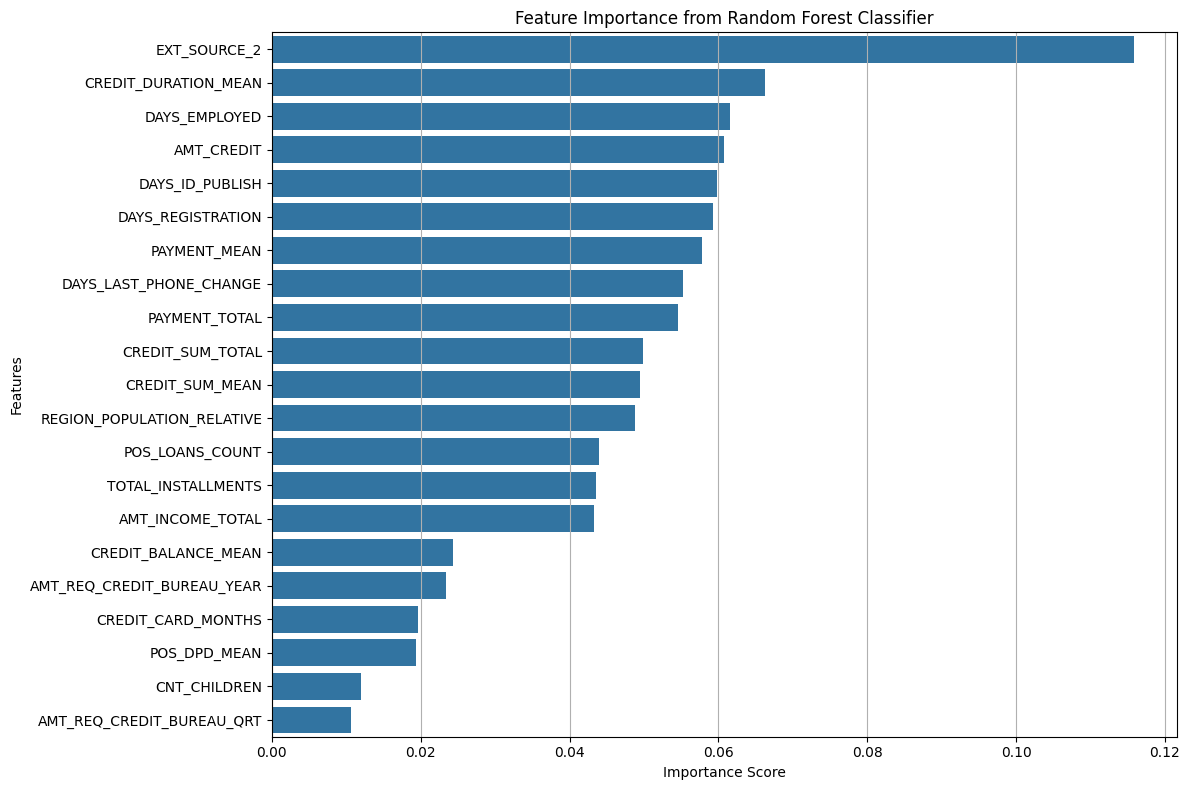

In [36]:
## Undersample Majority Class

#  Define numerical and categorical columns
numerical_cols = X_train1.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X_train1.select_dtypes(include=['object']).columns.tolist()

# Imputers
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Build transformers list conditionally
transformers = []
if len(numerical_cols) > 0:
    transformers.append(('num', Pipeline(steps=[
        ('imputer', numerical_imputer), 
        ('scaler', StandardScaler())
    ]), numerical_cols))
if len(categorical_cols) > 0:
    transformers.append(('cat', Pipeline(steps=[
        ('imputer', categorical_imputer), 
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols))

# Create the ColumnTransformer
preprocessor = ColumnTransformer(transformers=transformers)

# Create the pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersample', RandomUnderSampler(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Fit the pipeline on the training data
pipeline.fit(X_train1, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test1)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance Extraction
try:
    feature_names = list(numerical_cols)
    if len(categorical_cols) > 0:
        onehot_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        categorical_feature_names = onehot_encoder.get_feature_names_out(categorical_cols)
        feature_names = list(categorical_feature_names) + list(numerical_cols)
    
    # Get feature importances from the classifier
    importance = pipeline.named_steps['classifier'].feature_importances_
    
    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })

    # Set the threshold for feature importance
    importance_threshold = 0.01
    feature_importance_df = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Visualization
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importance from Random Forest Classifier')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

except NotFittedError:
    print("The OneHotEncoder instance is not fitted. Ensure that the pipeline is fitted correctly.")
except Exception as e:
    print(f"An error occurred: {e}")


In [44]:
X_train1

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_SUM_TOTAL,CREDIT_SUM_MEAN,CREDIT_OVERDUE_MAX,CREDIT_DURATION_MEAN,POS_LOANS_COUNT,POS_DPD_MEAN,CREDIT_BALANCE_MEAN,CREDIT_CARD_MONTHS,PAYMENT_TOTAL,PAYMENT_MEAN,TOTAL_INSTALLMENTS
181648,2,90000.0,227520.0,0.008230,-946,-6378.0,-4670,0,0,0,0,0.289573,0.0,1.000000,1.000000,5.679000e+05,113580.000000,0.000000,-1175.800000,34.0,0.000000,213473.232857,21.000000,550660.815,9660.716053,57.0
229245,0,90000.0,161730.0,0.003069,-92,-1292.0,-1994,0,0,0,1,0.514261,-509.0,0.265474,1.899974,1.955807e+06,378080.200789,4.772759,-1083.047110,31.0,0.000000,71459.926952,37.143605,263064.645,9743.135000,27.0
122525,0,135000.0,728847.0,0.020713,-1646,-7951.0,-2842,0,0,0,0,0.486906,-1474.0,0.000000,2.000000,1.099251e+06,274812.750000,0.000000,-1358.500000,5.0,0.000000,71459.926952,37.143605,51958.485,12989.621250,4.0
306311,0,135000.0,474183.0,0.011703,-1651,-1033.0,-1345,0,0,0,0,0.675705,-2016.0,0.000000,4.000000,1.197855e+06,399285.000000,0.000000,-2005.333333,84.0,0.000000,71459.926952,37.143605,1471327.965,17943.023963,82.0
300658,0,180000.0,254700.0,0.006629,-977,-2873.0,-852,0,0,0,0,0.154565,-695.0,0.265474,1.899974,1.955807e+06,378080.200789,4.772759,-1083.047110,12.0,0.000000,71459.926952,37.143605,37066.230,3369.657273,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31304,1,135000.0,405000.0,0.035792,-595,-6831.0,-4420,0,0,0,0,0.549668,-379.0,0.265474,1.899974,1.955807e+06,378080.200789,4.772759,-1083.047110,12.0,0.000000,71459.926952,37.143605,91714.725,7642.893750,12.0
121193,0,157500.0,272520.0,0.018801,-4334,-8490.0,-2561,0,0,0,0,0.569702,-374.0,1.000000,4.000000,9.009000e+05,180180.000000,13.000000,-751.000000,37.0,0.432432,24492.050000,9.000000,198316.125,3888.551471,51.0
248504,0,90000.0,246357.0,0.025164,365243,-8975.0,-4636,0,0,0,0,0.461966,-1689.0,0.000000,1.000000,8.550000e+05,171000.000000,0.000000,-1519.200000,33.0,0.000000,71459.926952,37.143605,278914.185,8716.068281,32.0
175469,0,112500.0,810000.0,0.018209,365243,-10162.0,-4636,0,0,0,0,0.459173,-1329.0,0.000000,5.000000,6.750000e+04,67500.000000,0.000000,-1884.000000,64.0,0.265625,71459.926952,37.143605,1814637.240,20620.877727,88.0


In [38]:
# Make predictions on the test set
# y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability of positive class
y_pred_adjusted = (y_pred_proba >= 0.3).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)

print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

Accuracy: 0.24, Precision: 0.09, Recall: 0.94, F1-Score: 0.17


In [39]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[38254 18284]
 [ 1807  3158]]


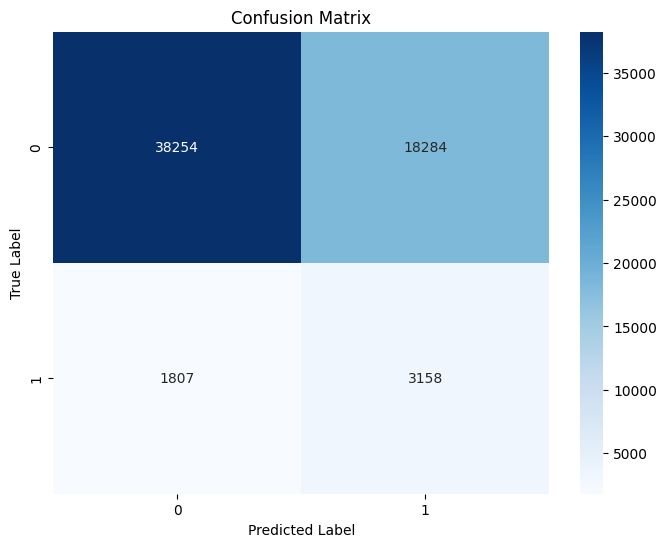

In [40]:
# Plot confusion matrix

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

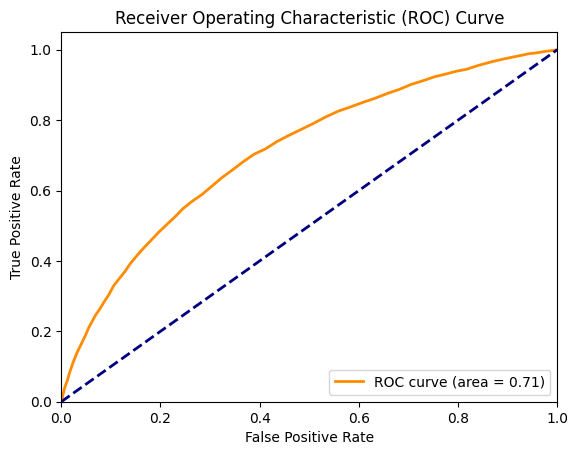

In [41]:
# ROC curve and AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [42]:
# #Hyperparameter Tuning

# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid for Random Forest
# param_grid = {
#     'classifier__n_estimators': [50, 100, 200],
#     'classifier__max_depth': [None, 10, 20],
#     'classifier__min_samples_split': [2, 5, 10],
# }

# # Perform Grid Search
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters
# print("Best Hyperparameters:", grid_search.best_params_)


In [43]:
## Model Comparison and Selection

from sklearn.linear_model import LogisticRegression

# Define other models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression()
}

# Iterate through models and evaluate performance
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")


Random Forest Accuracy: 0.92
Logistic Regression Accuracy: 0.92
